# Mol2vec with CATBoost for Viscosity Predictions

mol2vec shape: (5695, 300)
features shape: (5695, 301)
Learning rate set to 0.052028
0:	learn: 0.6796898	total: 9.79ms	remaining: 9.78s
100:	learn: 0.1972795	total: 786ms	remaining: 6.99s
200:	learn: 0.1360335	total: 1.58s	remaining: 6.3s
300:	learn: 0.1073843	total: 2.35s	remaining: 5.46s
400:	learn: 0.0894275	total: 3.14s	remaining: 4.7s
500:	learn: 0.0772353	total: 4.03s	remaining: 4.01s
600:	learn: 0.0680297	total: 5s	remaining: 3.32s
700:	learn: 0.0611388	total: 5.99s	remaining: 2.56s
800:	learn: 0.0552098	total: 6.97s	remaining: 1.73s
900:	learn: 0.0505205	total: 7.96s	remaining: 875ms
999:	learn: 0.0462487	total: 8.95s	remaining: 0us
Test MAE: 0.05631591201861893
Test RMSE: 0.10572430855444111
Test R2: 0.9757487133683524


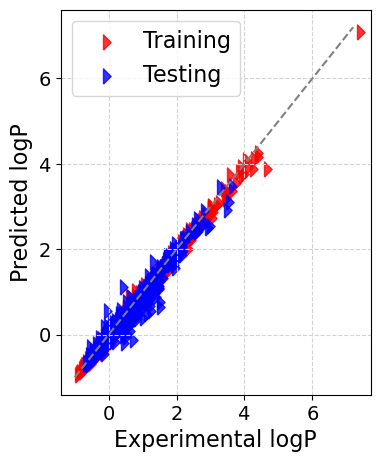

In [ ]:
import math
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from gensim.models import word2vec
from sklearn import preprocessing
from catboost import CatBoostRegressor

# Loading organic solvents viscosity data
input_dir = 'D:/Postdoc-Work/Manuacripts/NLP-Organic_Solvents-Properties/Comm Chemistry/Revisions_R1/Data_ML-pred/Mol2vec/Viscosity/'
dataset = pd.read_csv(input_dir + 'Oragnic-Solvents_Viscosity_All.csv', encoding='unicode_escape')

mol_smiles = dataset['CANON_SMILES']
log_visc = dataset['log_visc']
temperature = dataset['Temperature (K)']

# Load the pre-trained Mol2vec model
model_path = 'D:/Postdoc-Work/Results/ML_Codes/Scikit-Learn_ML/Models_MM/Organic-Solvents_Viscosity/mol2vec-master/examples/models/model_300dim.pkl'
model = word2vec.Word2Vec.load(model_path)

# Extraction of identifiers from molecules
os_smiles = [Chem.MolFromSmiles(x) for x in mol_smiles]
os_sentences = [mol2alt_sentence(x, 1) for x in os_smiles]

# Define the DfVec class if not already defined
class DfVec:
    def __init__(self, vector):
        self.vector = vector

def sentences2vec(sentences, model, unseen='UNK'):
    vectors = []
    for sentence in sentences:
        vec = []
        for word in sentence:
            if word in model.wv.key_to_index:
                vec.append(model.wv[word])
            else:
                if unseen in model.wv.key_to_index:
                    vec.append(model.wv[unseen])
                else:
                    vec.append(np.zeros(model.vector_size))
        vectors.append(np.sum(vec, axis=0))
    return vectors

# Convert sentences to vectors
os_mol2vec = [DfVec(x) for x in sentences2vec(os_sentences, model, unseen='UNK')]

# Use the correct attribute name 'vector' instead of 'vec'
np_os_mol2vec = np.array([x.vector for x in os_mol2vec])
print("mol2vec shape:", np_os_mol2vec.shape)

# Combine Mol2vec features and temperature
features = np.hstack((np_os_mol2vec, temperature.values.reshape(-1, 1)))

print("features shape:", features.shape)

# Simple train-test split
X_train, X_test, y_train, y_test, smiles_train, smiles_test = train_test_split(
    features, log_visc, mol_smiles, test_size=0.2, random_state=365)

# Train CatBoost
cat_model = CatBoostRegressor(verbose=100)
cat_model.fit(X_train, y_train)

# Predict on train
y_pred_train = cat_model.predict(X_train)
train_df = pd.DataFrame({
    'SMILES': smiles_train.reset_index(drop=True),
    'viscosity_actual': y_train.reset_index(drop=True),
    'viscosity_vap_pred': y_pred_train
})
train_df.to_csv('CATBoost_Mol2vec-Training_Viscosity-RS365.csv', index=False)

# Predict on test
y_pred_test = cat_model.predict(X_test)
test_df = pd.DataFrame({
    'SMILES': smiles_test.reset_index(drop=True),
    'viscosity_actual': y_test.reset_index(drop=True),
    'viscosity_pred': y_pred_test
})
test_df.to_csv('CATBoost_Mol2vec-Testing_Viscosity-RS365.csv', index=False)

# Print metrics
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("Test RMSE:", math.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Test R2:", r2_score(y_test, y_pred_test))

# Scatterplot
plt.figure(figsize=(4, 5))
ln = np.arange(min(min(y_train), min(y_test)), max(max(y_train), max(y_test)), 0.2)
plt.plot(ln, ln, 'gray', linestyle='--')

plt.scatter(y_train, y_pred_train, color='red', label='Training', alpha=0.8,
            marker=MarkerStyle("D", fillstyle="right"), s=60)
plt.scatter(y_test, y_pred_test, color='blue', label='Testing', alpha=0.8,
            marker=MarkerStyle("D", fillstyle="right"), s=60)

plt.xlabel('Experimental logP', fontsize=16)
plt.ylabel('Predicted logP', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(color='#D3D3D3', linestyle='--', which='both', axis='both')
plt.legend(loc='upper left', fontsize=16)
plt.show()